In [2]:
import pandas as pd
from UsefulFunctions import * 
from dpks.quant_matrix import QuantMatrix
from config_path import MS_DATA_PATH

Base path: ..


In [2]:
df = pd.read_csv(f'{MS_DATA_PATH}/220316_ghost_nrt_filtered.tsv', sep='\t')
design_matrix = pd.read_csv(f'{MS_DATA_PATH}/design_matrix_group_de_early_time_points_subtypes.tsv', sep='\t')

GroupOneCols = design_matrix[design_matrix['Group'] == 1]['Sample'].values
GroupTwoCols = design_matrix[design_matrix['Group'] == 2]['Sample'].values

quant_matrix = QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/220316_ghost_nrt_filtered.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/design_matrix_group_de_early_time_points_subtypes.tsv"
)

quantified_proteins = (
    quant_matrix
    .filter() # filter for q-values (removes rows with low q value (peptides), Q = 0.01) and removes decoys
    .normalize(method="mean", use_rt_sliding_window_filter = True) # best type of normalization is RT-sliding window
    .quantify(method="maxlfq") # play around with minimum_subgroups (default is set 1)
)

compare_df = quantified_proteins.compare_groups(
    method='linregress',
    group_a=1,
    group_b=2,
    min_samples_per_group = 2, # play around with this 
    level='protein',
    
).to_df()

df = compare_df.dropna(subset=['CorrectedPValue'])
df

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/dpks/normalization.py:116: RuntimeWarning: Mean of empty slice
  sample_means = np.nanmean(X, axis=0)


,Protein,Group1Mean,Group2Mean,Log2FoldChange1-2,PValues1-2,Group1RepCounts,Group2RepCounts,CorrectedPValue,TM_M2012_010,TM_M2012_011,...,TM_M2012_177,TM_M2012_178,TM_M2012_182,TM_M2012_183,TM_M2012_186,TM_M2012_188,TM_M2012_189,TM_M2012_196,TM_M2012_197,TM_M2012_198
0,P06396,21.288717,21.226708,0.062010,0.694861,30,42,0.721447,21.690603,20.691873,...,20.419413,21.028937,21.542064,21.509333,21.198022,21.245511,21.200419,23.029393,23.389134,23.470304
1,P10643,21.516173,21.613422,-0.097249,0.503560,30,42,0.625305,21.677649,21.190349,...,21.893203,21.188014,21.371173,21.436145,21.356409,21.040272,21.362647,21.331875,21.524378,21.930228
2,P03952,20.936229,20.612498,0.323731,0.045767,30,42,0.149304,21.023477,20.770036,...,20.505599,20.608387,20.970957,20.752389,21.042518,20.957229,21.163873,22.332772,22.704704,22.773377
3,P02750,23.510573,23.954318,-0.443745,0.003362,30,42,0.023420,22.807610,23.269826,...,23.784981,24.566548,24.806581,24.787613,22.859750,22.901881,23.686287,24.103840,23.764547,24.052968
4,Q04756,19.586920,18.838137,0.748783,0.000072,30,41,0.001191,19.657972,19.115191,...,18.220235,18.721893,18.931209,18.973254,19.296811,18.608288,19.034313,20.708523,20.283616,20.454671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,P01616,20.806397,21.611803,-0.805406,0.013882,29,41,0.067931,20.018119,21.708534,...,19.232137,21.177845,21.418106,21.232295,20.519050,21.596102,21.879924,21.306429,22.651262,19.727565
1030,P04220,20.924360,20.316393,0.607967,0.308745,9,25,0.474321,NaN,NaN,...,NaN,NaN,20.140466,19.847373,NaN,NaN,18.953303,21.759646,19.886303,20.529990
1032,P07333,19.402438,19.907729,-0.505291,0.186276,9,17,0.363422,18.987071,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.349059,NaN,NaN
1033,P18136,20.043648,19.715824,0.327824,0.719230,4,6,0.732731,NaN,NaN,...,NaN,19.698518,NaN,NaN,21.028617,NaN,NaN,NaN,NaN,NaN


In [3]:
df = pd.read_csv('../data/ms/covid/QuantMatrix.tsv', sep="\t")
design = pd.read_csv('../data/ms/covid/design.csv')
GroupOneCols = design[design['Group'] == 1]['Samples']
GroupTwoCols = design[design['Group'] == 2]['Samples']
print(len(GroupOneCols), len(GroupTwoCols))
print(GroupOneCols)

281 406
9        520_TOF1_AF_017_ZeBanC_P1_B2
10       520_TOF1_AF_018_ZeBanC_P1_B3
11       520_TOF1_AF_020_ZeBanC_P1_B4
13       520_TOF1_AF_023_ZeBanC_P1_B7
16      520_TOF1_AF_027_ZeBanC_P1_B10
                    ...              
677    710_TOF1_LS_465_ZeBanc2_P4_G11
681     710_TOF1_LS_471_ZeBanc2_P4_A8
683     710_TOF1_LS_475_ZeBanc2_P2_H1
684    710_TOF1_LS_476_ZeBanc2_P3_F11
686     710_TOF1_LS_478_ZeBanc2_P3_C2
Name: Samples, Length: 281, dtype: object


In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

protein_labels = df['Protein'].values

df1 = df[GroupOneCols].T
df2 = df[GroupTwoCols].T
df1.columns = protein_labels
df2.columns = protein_labels
y = [1 for x in GroupOneCols] + [2 for x in GroupTwoCols] 
y_array = np.array(y) - 1

df_X = pd.concat([df1,df2]).fillna(0)
X = df_X.to_numpy()

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
df_X_scaled = pd.DataFrame(X_scaled)
df_X_scaled.columns = df_X.columns
df_X_scaled

,P00747,P02675,P02768,P02787,P00450,P02751,P10643,P02671,P01024,P01880,...,P15814,Q9HCU4,A0A0C4DH33,P07359,P01743,P01764,A0A0B4J1X8,P02786,A0A0B4J1V1,A0A0B4J1V2
0,-1.195228,-0.031473,-0.976171,-1.071961,-1.604871,0.820319,-1.731841,-0.075159,-1.338523,-0.931031,...,-0.612498,0.856556,-0.646477,-0.767657,-0.548892,-0.807439,-0.328721,3.549904,-0.346028,-0.843265
1,0.202442,-0.155822,0.154948,0.529730,0.369650,-0.316527,-0.245516,-0.401479,0.222331,-0.899930,...,-1.401060,-0.537882,-0.407388,1.628158,-0.081103,-0.349943,0.956389,1.934884,-0.346028,-0.843265
2,0.345746,3.261700,-1.509264,-0.672687,-0.835275,1.033014,-1.218068,2.721744,-0.177105,-0.899930,...,-1.401060,2.670761,-1.809690,-0.767657,0.202192,-0.130379,-0.606813,-0.632556,-0.346028,-0.843265
3,0.238341,-0.652213,0.816096,1.634720,-0.513120,-0.281357,-0.613808,-0.779482,-0.495097,0.669868,...,0.307182,-0.567455,-0.446833,0.888781,-0.477649,-0.587424,0.090899,-0.632556,-0.346028,-0.843265
4,0.070155,-0.587146,0.017558,0.517397,-0.649328,-0.144837,-0.474597,-0.707625,-0.038483,0.315908,...,0.013873,-0.336729,1.965843,1.014173,-0.156598,1.276075,-0.084751,-0.632556,-0.346028,-0.843265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,-0.131582,0.421921,-0.855022,-0.621688,0.469314,-0.392931,-0.802070,0.503401,0.810331,-0.405975,...,0.156668,0.066754,0.127305,-0.767657,0.275891,-0.620304,-0.606813,-0.632556,-0.346028,0.235022
683,-0.749592,0.179134,0.455929,-0.927578,-0.448983,-0.194056,-1.022974,0.174605,0.109693,-0.588018,...,0.110281,0.641021,0.198090,-0.767657,0.233065,-0.795186,-0.606813,-0.632556,-0.346028,-0.158091
684,-2.093096,-0.148520,0.523399,-1.387928,-1.284706,-0.542726,-1.548105,0.012666,-0.969840,-0.451055,...,-0.268709,0.090273,0.096328,-0.767657,-0.943657,-0.780196,0.355425,-0.632556,-0.346028,-0.297153
685,-0.149506,-0.367725,-0.368997,-1.026153,0.293279,-0.286811,-0.763878,-0.275365,-1.273134,-0.708842,...,0.306717,-0.693891,-0.436782,-0.767657,-1.146054,-1.015667,-0.606813,-0.632556,-0.346028,-0.261443


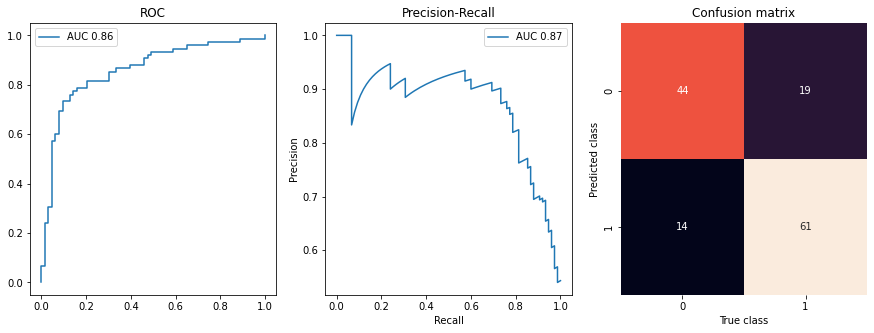

Accuracy: 0.91 accuracy with a standard deviation of 0.03
F1: 0.89 with a standard deviation of 0.03
Recall: 0.89 accuracy with a standard deviation of 0.05
Precision: 0.89 with a standard deviation of 0.04


In [5]:
# SVM
from sklearn import svm
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit


clf_svm = svm.SVC(probability=True)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

def make_roc(y_test, y_pred_proba):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[:,1])
    y_hat = np.argmax(y_pred_proba, axis=1)
    confusion_matrix = metrics.confusion_matrix(y_test, y_hat)
    auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
    lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test,  y_pred_proba[:,1])
    pr_auc = metrics.auc(lr_recall, lr_precision)
    ax[0].plot(fpr,tpr,label=f"AUC {auc:.2f}")
    ax[0].set_title('ROC')
    ax[0].legend()
    ax[1].plot(lr_recall, lr_precision, label=f"AUC {pr_auc:.2f}")
    ax[1].set_title('Precision-Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_xlabel('Recall')
    ax[1].legend()
    ax[2] = sns.heatmap(confusion_matrix, annot=True, cbar=False)
    ax[2].set_ylabel('Predicted class')
    ax[2].set_xlabel('True class')
    ax[2].set_title('Confusion matrix')
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y_array, test_size=0.2, random_state=42)
clf_svm.fit(X_train, y_train)
y_pred_proba = clf_svm.predict_proba(X_test)
make_roc(y_test,y_pred_proba)
evaluate_classifier(clf_svm, X_scaled, y, cv)


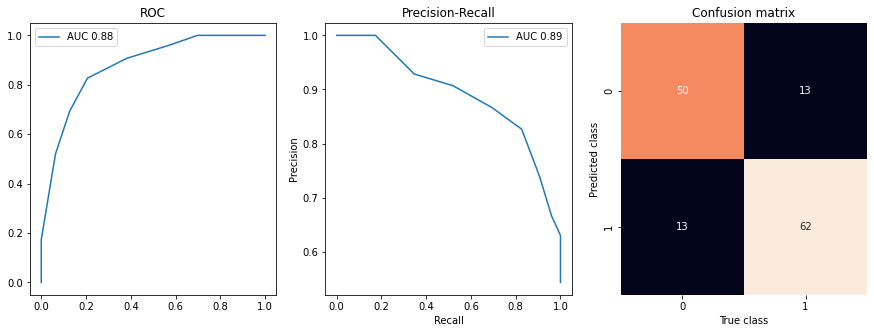

Accuracy: 0.86 accuracy with a standard deviation of 0.01
F1: 0.83 with a standard deviation of 0.02
Recall: 0.83 accuracy with a standard deviation of 0.04
Precision: 0.83 with a standard deviation of 0.03


In [6]:
# kNN
from sklearn.neighbors import KNeighborsClassifier

clf_kNN = KNeighborsClassifier(n_neighbors=10)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y_array, test_size=0.2, random_state=42)
clf_kNN.fit(X_train, y_train)
y_pred_proba = clf_kNN.predict_proba(X_test)
make_roc(y_test,y_pred_proba)
evaluate_classifier(clf_kNN, X_scaled, y, cv)


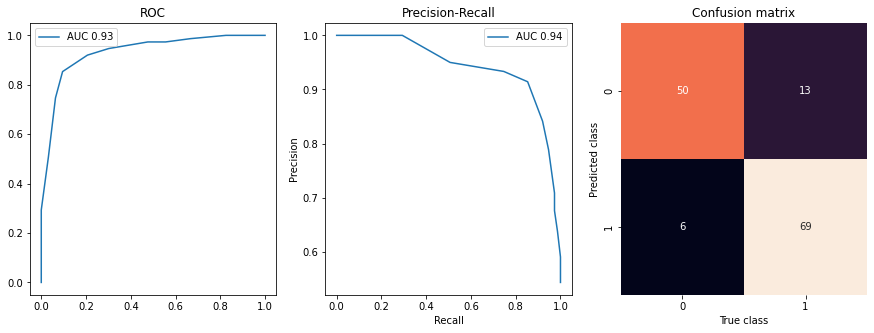

Accuracy: 0.87 accuracy with a standard deviation of 0.03
F1: 0.84 with a standard deviation of 0.04
Recall: 0.86 accuracy with a standard deviation of 0.07
Precision: 0.82 with a standard deviation of 0.02


In [7]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=10, random_state=42)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_proba = clf_rf.predict_proba(X_test)
make_roc(y_test,y_pred_proba)
evaluate_classifier(clf_rf, X_scaled, y, cv)

In [8]:
# XGBoost
from sklearn.ensemble import GradientBoostingClassifier
import shap

clf_GB = GradientBoostingClassifier(max_depth = 10, random_state=42)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
evaluate_classifier(clf_GB, X_scaled, y, cv)
explainer = shap.TreeExplainer(clf_GB.fit(df_X_scaled, y), df_X_scaled.iloc[:71, :])
shap_values = explainer(df_X_scaled)

shap.summary_plot(shap_values, df_X_scaled)


KeyboardInterrupt: 

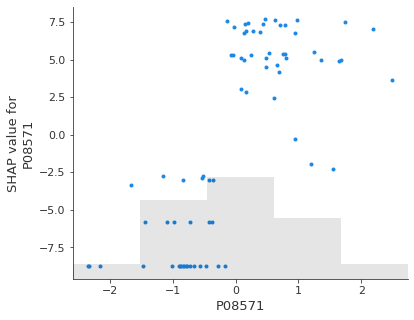

In [51]:
shap.plots.scatter(shap_values[:,'P08571'])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


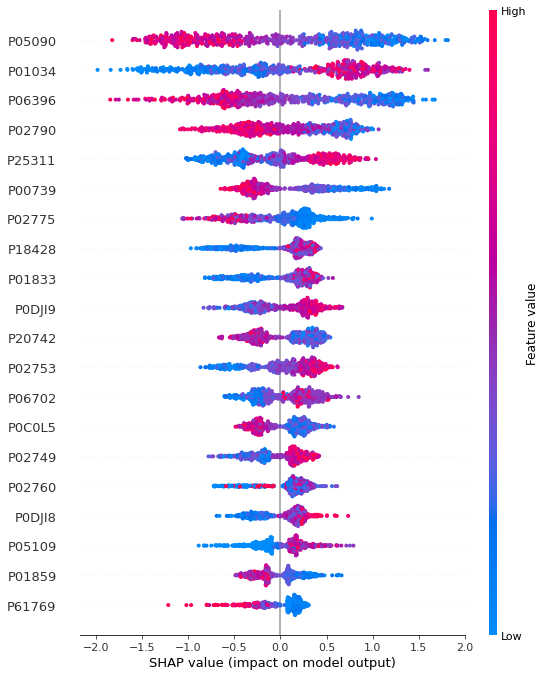

In [9]:
import xgboost

clf_xgb = xgboost.XGBClassifier(max_depth=30).fit(df_X_scaled, y_array)
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(df_X_scaled)

shap.summary_plot(shap_values, df_X_scaled)

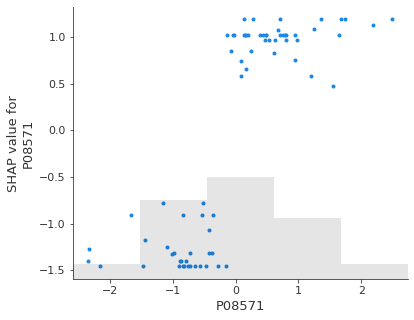

In [26]:
shap.plots.scatter(shap_values[:,'P08571'])

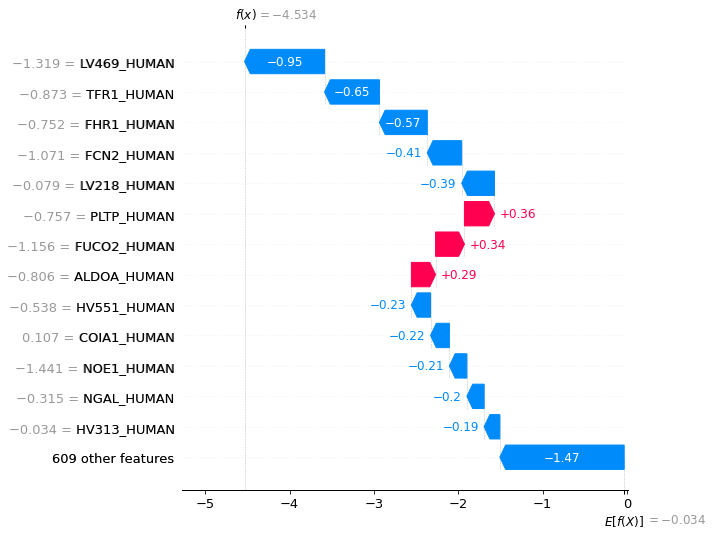

In [25]:
shap.plots.waterfall(shap_values[0], max_display=14)

In [26]:
# light GBM
import lightgbm as lgb

clf_lgb = lgb.LGBMClassifier(random_state = 42)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
evaluate_classifier(clf_lgb, df_X_scaled, y, cv)

Accuracy: 0.71 accuracy with a standard deviation of 0.07
F1: 0.71 with a standard deviation of 0.08
Recall: 0.73 accuracy with a standard deviation of 0.11
Precision: 0.70 with a standard deviation of 0.05


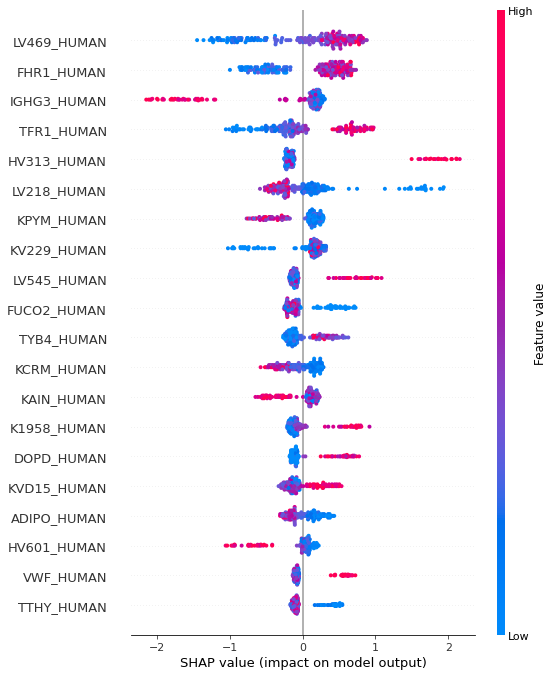

In [27]:
explainer = shap.TreeExplainer(clf_lgb.fit(df_X_scaled, y), df_X_scaled)
shap_values = explainer(df_X_scaled)

shap.summary_plot(shap_values, df_X_scaled)

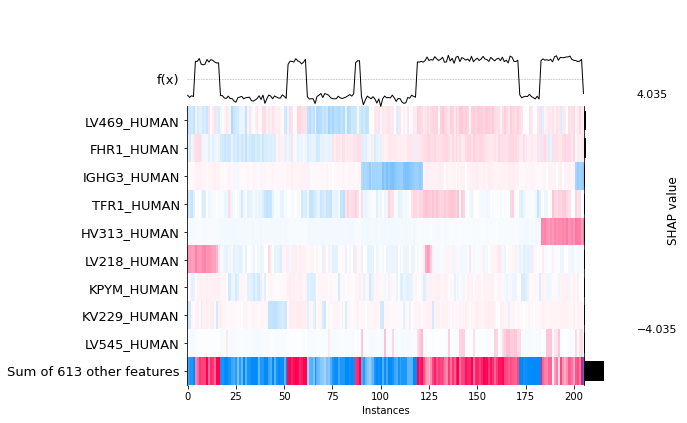

In [28]:
shap.plots.heatmap(shap_values)